In [4]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import scipy.io
import scipy
import random


class DataLoader:
    '''
    For load data and change shape to (x,y). x is the traing images and y is the label of the x.
    '''

    def __init__(self, file):

        self.data = scipy.io.loadmat(file, squeeze_me=True, struct_as_record=False)['mnist']
        self.train_images = self.data.train_images
        self.test_images = self.data.test_images
        self.train_labels = self.data.train_labels
        self.test_labels = self.data.test_labels

        # transform the raw data to binary data
        self.train_images = self.transform_images(self.train_images)
        self.test_images = self.transform_images(self.test_images)

        # reshape the training images to [784,1]
        self.train_images = [np.reshape(x, (784, 1)) for x in self.train_images]
        self.test_images = [np.reshape(x, (784, 1)) for x in self.test_images]

        labels = np.asarray(self.train_labels)
        selector = (labels == 3) | (labels == 7)
        self.train_labels = self.train_labels[selector]
        self.train_images = np.array(self.train_images)
        self.train_images = self.train_images[selector]
        ls= []
        for i in self.train_labels:
            if i == 3:
                ls.append([[1.],[0.]])
            else:
                ls.append([[0.],[1.]])
        self.train_labels = ls
        
        self.training_data = tuple(zip(self.train_images, self.train_labels))
        
#       test part
        labels = np.asarray(self.test_labels)
        selector = (labels == 3) | (labels == 7)
        self.test_labels = self.test_labels[selector]
        self.test_images = np.array(self.test_images)
        self.test_images = self.test_images[selector]
        ls= []
        for i in self.test_labels:
            if i == 3:
                ls.append([[1.],[0.]])
            else:
                ls.append([[0.],[1.]])
        self.test_labels = ls
        
        self.test_data = tuple(zip(self.test_images, self.test_labels))
        
        
    # function to reshape
    def transform_images(self, data):

        reshaped = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
        swapped_axes = np.swapaxes(reshaped, 0, 1)
        return swapped_axes * (1.0/256)
#         return (swapped_axes > 122) * 2.0 - 1

In [5]:
data = DataLoader('mnistALL.mat')

In [6]:
class Network(object):

    def __init__(self, sizes):
        '''
        sizes is the structure of the whole network shown by [first layer, second layer, ... , last year] as a list
        different waies to initialize the weights and biases
        '''
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
#better initialization of weights and biases 
#         self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
#         self.weights = [np.random.randn(y, x)/np.sqrt(x)
#                         for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    # the feedward calculation of the network
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    # stochastic gradient descent
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        error = []
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
#             random.shuffle(training_data)
# not shuffle yet
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                error.append(self.evaluate(test_data)/(len(test_data) * 1.0))
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
                
            else:
                print "Epoch {0} complete".format(j)
        return error

    def update_mini_batch(self, mini_batch, eta):

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))


def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
formatter = FuncFormatter(to_percent)

In [9]:
training_data = data.training_data
validation_data = data.test_data

print len(data.training_data[0][0])
initial_default_net = Network([784,100,2])
initial_default_error = initial_default_net.SGD(training_data, 150, 10, 0.005, test_data=validation_data)

784
Epoch 0: 838 / 2038
Epoch 1: 972 / 2038
Epoch 2: 1015 / 2038
Epoch 3: 1051 / 2038
Epoch 4: 1078 / 2038
Epoch 5: 1106 / 2038
Epoch 6: 1139 / 2038
Epoch 7: 1180 / 2038
Epoch 8: 1239 / 2038
Epoch 9: 1339 / 2038
Epoch 10: 1534 / 2038
Epoch 11: 1757 / 2038
Epoch 12: 1833 / 2038
Epoch 13: 1861 / 2038
Epoch 14: 1878 / 2038
Epoch 15: 1889 / 2038
Epoch 16: 1895 / 2038
Epoch 17: 1905 / 2038
Epoch 18: 1917 / 2038
Epoch 19: 1922 / 2038
Epoch 20: 1928 / 2038
Epoch 21: 1930 / 2038
Epoch 22: 1934 / 2038
Epoch 23: 1937 / 2038
Epoch 24: 1940 / 2038
Epoch 25: 1943 / 2038
Epoch 26: 1944 / 2038
Epoch 27: 1947 / 2038
Epoch 28: 1950 / 2038
Epoch 29: 1951 / 2038
Epoch 30: 1952 / 2038
Epoch 31: 1952 / 2038
Epoch 32: 1953 / 2038
Epoch 33: 1954 / 2038
Epoch 34: 1955 / 2038
Epoch 35: 1956 / 2038
Epoch 36: 1958 / 2038
Epoch 37: 1958 / 2038
Epoch 38: 1958 / 2038
Epoch 39: 1959 / 2038
Epoch 40: 1959 / 2038
Epoch 41: 1959 / 2038
Epoch 42: 1959 / 2038
Epoch 43: 1960 / 2038
Epoch 44: 1961 / 2038
Epoch 45: 1962 / 2

In [10]:
class Network(object):

    def __init__(self, sizes):
        '''
        sizes is the structure of the whole network shown by [first layer, second layer, ... , last year] as a list
        different waies to initialize the weights and biases
        '''
        self.num_layers = len(sizes)
        self.sizes = sizes
#         self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
#         self.weights = [np.random.randn(y, x)
#                         for x, y in zip(sizes[:-1], sizes[1:])]
        
#better initialization of weights and biases 
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    # the feedward calculation of the network
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    # stochastic gradient descent
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        error = []
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
#             random.shuffle(training_data)
# not shuffle yet
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                error.append(self.evaluate(test_data)/(len(test_data) * 1.0))
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
                
            else:
                print "Epoch {0} complete".format(j)
        return error

    def update_mini_batch(self, mini_batch, eta):

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))


def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [11]:
training_data = data.training_data
validation_data = data.test_data
initial_optimized_net = Network([784,100,2])
initial_optimized_error = initial_optimized_net.SGD(training_data, 150, 10, 0.005, test_data=validation_data)



Epoch 0: 1945 / 2038
Epoch 1: 1962 / 2038
Epoch 2: 1968 / 2038
Epoch 3: 1971 / 2038
Epoch 4: 1971 / 2038
Epoch 5: 1972 / 2038
Epoch 6: 1975 / 2038
Epoch 7: 1976 / 2038
Epoch 8: 1976 / 2038
Epoch 9: 1978 / 2038
Epoch 10: 1978 / 2038
Epoch 11: 1978 / 2038
Epoch 12: 1978 / 2038
Epoch 13: 1979 / 2038
Epoch 14: 1979 / 2038
Epoch 15: 1979 / 2038
Epoch 16: 1979 / 2038
Epoch 17: 1979 / 2038
Epoch 18: 1979 / 2038
Epoch 19: 1979 / 2038
Epoch 20: 1979 / 2038
Epoch 21: 1979 / 2038
Epoch 22: 1980 / 2038
Epoch 23: 1979 / 2038
Epoch 24: 1979 / 2038
Epoch 25: 1980 / 2038
Epoch 26: 1980 / 2038
Epoch 27: 1980 / 2038
Epoch 28: 1981 / 2038
Epoch 29: 1982 / 2038
Epoch 30: 1982 / 2038
Epoch 31: 1983 / 2038
Epoch 32: 1983 / 2038
Epoch 33: 1986 / 2038
Epoch 34: 1986 / 2038
Epoch 35: 1986 / 2038
Epoch 36: 1987 / 2038
Epoch 37: 1987 / 2038
Epoch 38: 1989 / 2038
Epoch 39: 1989 / 2038
Epoch 40: 1989 / 2038
Epoch 41: 1990 / 2038
Epoch 42: 1990 / 2038
Epoch 43: 1990 / 2038
Epoch 44: 1990 / 2038
Epoch 45: 1990 / 203

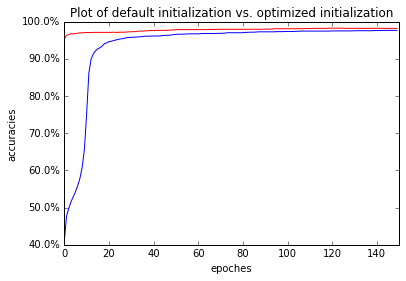

In [12]:
epoches = range(len(initial_optimized_error))
plt.plot(epoches, initial_default_error,'b')
plt.plot(epoches, initial_optimized_error,'r')


plt.title('Plot of default initialization vs. optimized initialization')
plt.xlabel('epoches')# make axis labels
plt.ylabel('accuracies')

plt.xlim(0.0, 150)
plt.ylim(0.4, 1.0)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()